# Blueprint for Modeling Investor Risk Tolerance and Enabling a Machine Learning–Based Robo-Advisor
*(Plano para Modelar a Tolerância ao Risco de Investidores e Criar um Robo-Advisor com Machine Learning)*

## Objetivo do Estudo de Caso

- **Construir um modelo de Machine Learning** para:
  - Prever a **tolerância** ou **aversão ao risco** de um investidor.

- **Aplicação do modelo:**
  - Integrar o modelo em um **painel de controle (dashboard)** de um **robo-advisor**.

- **Como:**  
  Usando um modelo de **regressão supervisionada**, onde:
  - A **variável prevista** é a tolerância ao risco.
  - As **variáveis preditoras** são atributos:
    - Demográficos
    - Financeiros
    - Comportamentais

- **Fonte dos Dados:**  
  - **Survey of Consumer Finances (SCF)** — Pesquisa de Finanças do Consumidor.
  - Realizada pelo **Federal Reserve Board** (Banco Central dos EUA).
  - Dados coletados em dois momentos:
    - **2007** (antes da crise financeira).
    - **2009** (depois da crise financeira).

- **Importância dos Dados:**  
  Permitem analisar **como as famílias mudaram seus investimentos** após a crise financeira global de 2008.

- **Observação:**  
  Consulte o **dicionário de dados** para mais informações sobre a pesquisa.


### Libnames

In [11]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for Deep Learning Models (usando tensorflow.keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Libraries for Statistical Models
import statsmodels.api as sm

# Libraries for Saving the Model
from pickle import dump
from pickle import load

### Carrengando os dados

In [13]:
caminho_data = '/Users/jacksoncosta/Documents/02_DATASCIENCE/01_FIN_MODELS/REGRESSION/01_RISK_TOLERANCE_ROBO_ADV/data/SCFP2009panel.xlsx'

In [15]:
dataset = pd.read_excel(caminho_data)

In [16]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [17]:
type(dataset)

pandas.core.frame.DataFrame

In [18]:
dataset.shape

(19285, 515)

## Preparando a Variável Predita

- **Fonte dos dados:**  
  - Survey of Consumer Finances (SCF) - dados de 2007 (pré-crise) e 2009 (pós-crise).

- **Objetivo:**  
  - Preparar a **"verdadeira" tolerância ao risco** como variável alvo para o modelo de machine learning.

### Passos:

1. **Calcular ativos:**
   - **Ativos de Risco:** fundos mútuos, ações, títulos, commodities, imóveis e capital humano estimado.
   - **Ativos Livres de Risco:** contas correntes, poupanças, certificados de depósito e equivalentes em dinheiro.

2. **Medir a tolerância ao risco:**
   - Razão entre **ativos de risco** e **total de ativos**.

3. **Normalizar os dados:**
   - Ajustar a razão com base na variação do **S&P500** entre 2007 (1478) e 2009 (948).

4. **Definição de Investidores Inteligentes:**
   - Investidores que **mudam sua tolerância ao risco em menos de 10%** entre 2007 e 2009.

### Observação

- A proposta principal é mostrar a **aplicação de machine learning** em finanças comportamentais, mais do que atingir a precisão máxima.


`NOTA :`

O S&P 500 (Standard & Poor's 500) é um dos principais índices de ações do mercado financeiro global, representando o desempenho das 500 maiores empresas de capital aberto listadas nas bolsas dos Estados Unidos (como NYSE e NASDAQ). Ele é amplamente utilizado como referência para medir a saúde da economia americana e do mercado de capitais.

In [21]:
# Média SP500 Durante 2007 E 2009 (SP500)

Average_SP500_2007=1478
Average_SP500_2009=948

# Isso significa que, em média, o índice esteve mais alto em 2007 e mais baixo em 2009.


#Tolerancia de Risco em 2007
dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07'] 
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])


#Risk Tolerance 2009
dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09'] 
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)

### Dicionário de Dados - Tolerância ao Risco (2007 e 2009)

Variáveis Base 2007

| Variável       | Descrição                                                                 | Tipo        | Categoria       |
|----------------|---------------------------------------------------------------------------|-------------|-----------------|
| **LIQ07**      | Ativos líquidos (contas correntes, poupança, etc.)                        | Numérico ($)| Livre de Risco  |
| **CDS07**      | Certificados de depósito bancário                                         | Numérico ($)| Livre de Risco  |
| **SAVBND07**   | Títulos de poupança (e.g., Treasury Bonds)                                | Numérico ($)| Livre de Risco  |
| **CASHLI07**   | Outros ativos líquidos (fundos monetários, etc.)                          | Numérico ($)| Livre de Risco  |
| **NMMF07**     | Fundos mútuos não monetários (investimentos em ações/títulos)             | Numérico ($)| Risco           |
| **STOCKS07**   | Ações individuais diretamente detidas                                     | Numérico ($)| Risco           |
| **BOND07**     | Títulos corporativos ou outros títulos de risco                           | Numérico ($)| Risco           |

Variáveis Calculadas 2007

| Variável       | Fórmula                                      | Descrição                                  | Escala     |
|----------------|----------------------------------------------|-------------------------------------------|------------|
| **RiskFree07** | `LIQ07 + CDS07 + SAVBND07 + CASHLI07`        | Soma de todos os ativos livres de risco   | $          |
| **Risky07**    | `NMMF07 + STOCKS07 + BOND07`                 | Soma de todos os ativos de risco          | $          |
| **RT07**       | `Risky07 / (Risky07 + RiskFree07)`           | Proporção de ativos de risco (2007)       | 0-1 (100%) |

Variáveis Base 2009

| Variável       | Descrição (equivalente a 2007)               | Tipo        | Categoria       |
|----------------|----------------------------------------------|-------------|-----------------|
| **LIQ09**      | (idem LIQ07)                                 | Numérico ($)| Livre de Risco  |
| **CDS09**      | (idem CDS07)                                 | Numérico ($)| Livre de Risco  |
| **SAVBND09**   | (idem SAVBND07)                              | Numérico ($)| Livre de Risco  |
| **CASHLI09**   | (idem CASHLI07)                              | Numérico ($)| Livre de Risco  |
| **NMMF09**     | (idem NMMF07)                                | Numérico ($)| Risco           |
| **STOCKS09**   | (idem STOCKS07)                              | Numérico ($)| Risco           |
| **BOND09**     | (idem BOND07)                                | Numérico ($)| Risco           |

Variáveis Calculadas 2009

| Variável       | Fórmula                                      | Descrição                                  | Escala     |
|----------------|----------------------------------------------|-------------------------------------------|------------|
| **RiskFree09** | `LIQ09 + CDS09 + SAVBND09 + CASHLI09`        | Soma de ativos livres de risco (2009)     | $          |
| **Risky09**    | `NMMF09 + STOCKS09 + BOND09`                 | Soma de ativos de risco (2009)            | $          |
| **RT09**       | `(Risky09/(Risky09+RiskFree09))*(948/1478)`  | Tolerância ajustada pela crise (2009)     | 0-1 (100%) |

Variáveis Externas

| Variável               | Valor  | Descrição                             |
|------------------------|--------|---------------------------------------|
| **Average_SP500_2007** | 1,478  | Média do S&P 500 em 2007 (base)       |
| **Average_SP500_2009** | 948    | Média do S&P 500 em 2009 (pós-crise)  |

Legenda
- **$**: Valores monetários em dólares americanos
- **0-1**: Proporção (pode ser interpretada como 0-100%)
- **Ajuste RT09**: Incorpora a desvalorização do mercado (948/1478 ≈ 0.64)

In [22]:
dataset2 = copy.deepcopy(dataset)  
dataset.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RT07,RiskFree09,Risky09,RT09
0,1,11,11668.134198,47,3,12,2,1,0,2,...,0.0,93.125197,270.403054,57,7994.813847,0.0,0.0,16000,17000,0.330422
1,1,12,11823.456494,47,3,12,2,1,0,2,...,0.0,93.125197,249.593620,57,7994.813847,0.0,0.0,19000,18000,0.312036
2,1,13,11913.228354,47,3,12,2,1,0,2,...,0.0,93.125197,209.233358,57,7984.457871,0.0,0.0,13000,12000,0.307876
3,1,14,11929.394266,47,3,12,2,1,0,2,...,0.0,93.125197,209.273158,57,7984.457871,0.0,0.0,25000,13000,0.219429
4,1,15,11917.722907,47,3,12,2,1,0,2,...,0.0,93.125197,232.690767,57,7994.813847,0.0,0.0,17000,12000,0.265410


Vamos calcular a variação percentual na tolerância ao risco entre 2007 e 2009.

In [23]:
dataset2['PercentageChange'] = np.abs(dataset2['RT09']/dataset2['RT07']-1)

In [31]:
dataset2.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RT07,RiskFree09,Risky09,RT09,PercentageChange
5,2,21,255.421402,56,4,17,4,1,2,5,...,-51.718701,131.926121,57,337604.83344,1.387701e+06,0.804322,230000,350000,0.387056,0.518779
6,2,22,265.151248,56,4,17,4,1,2,5,...,-51.718701,131.926121,57,337604.83344,1.480905e+06,0.814351,230000,350000,0.387056,0.524706
7,2,23,254.044527,56,4,17,4,1,2,5,...,-51.718701,131.926121,57,337604.83344,1.164012e+06,0.775172,230000,350000,0.387056,0.500684
8,2,24,252.877840,56,4,17,4,1,2,5,...,-51.718701,131.926121,57,337604.83344,2.489577e+06,0.880586,230000,350000,0.387056,0.560456
9,2,25,245.023339,56,4,17,4,1,2,5,...,-51.718701,131.926121,57,337604.83344,1.862005e+06,0.846516,230000,350000,0.387056,0.542766


In [24]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset2.isnull().values.any())

Null Values = True


In [27]:
# Drop the rows containing NA
dataset2 = dataset2.dropna(axis=0)

# Drop rows containing NaN, inf, or -inf
dataset2 = dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

# Checking for any null values
print('Null Values =', dataset2.isnull().values.any())

Null Values = False


`Visualizando Tolerancia ao Risco em 2007`

<Axes: xlabel='RT07'>

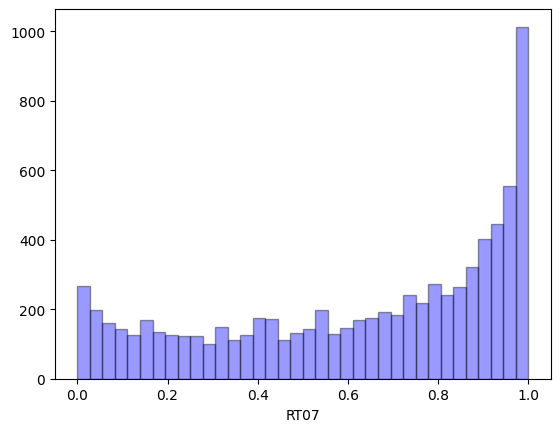

In [28]:
sns.distplot(dataset2['RT07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

`Observando a tolerância ao risco em 2007, percebemos que um número significativo de indivíduos apresentava uma tolerância próxima de um, o que significa que seus investimentos estavam mais concentrados em ativos de risco.`

`Visualizando Tolerancia de ao risco em 2009`

<Axes: xlabel='RT09'>

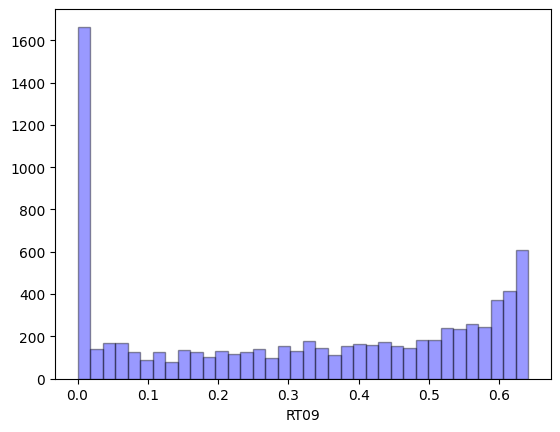

In [29]:
sns.distplot(dataset2['RT09'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

`Claramente, o comportamento dos indivíduos se inverteu em 2009 após a crise, e a maior parte dos investimentos passou a estar concentrada em ativos livres de risco.
De maneira geral, a tolerância ao risco diminuiu, o que é evidenciado pelo fato da maioria das tolerâncias ao risco estarem próximas de 0 em 2009.
No próximo passo, selecionamos os investidores "inteligentes", ou seja, aqueles cuja mudança na tolerância ao risco entre 2007 e 2009 foi inferior a 10%.`

In [30]:
dataset3 = copy.deepcopy(dataset2)  

In [32]:
dataset3 = dataset3[dataset3['PercentageChange']<=.1]

- Filtra o dataset original para selecionar apenas os investidores cuja mudança na tolerância ao risco (RT) entre 2007 e 2009 foi menor ou igual a 10% (ou seja, |RT09 - RT07| ≤ 0.1).

- Esses investidores são considerados "inteligentes" porque mantiveram sua estratégia de risco de forma consistente, mesmo durante a crise financeira (não reagiram de forma abrupta ao pânico do mercado).

- Por que 10%?
É um limiar arbitrário (definido no estudo) para identificar investidores com comportamento estável.

    Investidores com variações maiores podem ter:

        Aumentado demais o risco (especulação) ou

        Reduzido demais o risco (pânico).

In [33]:
dataset3.shape

(355, 522)

### TrueRiskTolerance

Atribuímos a verdadeira tolerância ao risco como a média da tolerância ao risco desses investidores "inteligentes" entre 2007 e 2009.
Esta média será a variável prevista neste estudo de caso. O objetivo é prever a verdadeira tolerância ao risco de um indivíduo, com base em suas características demográficas, financeiras e em sua disposição para correr riscos.



In [34]:
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09']) / 2

In [35]:
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

In [36]:
dataset3

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RiskFree09,Risky09,TrueRiskTolerance
60,14,141,13732.681713,77,6,12,2,1,0,6,...,12.956921,0.0,1000.080237,-35.900702,57,1.170225e+04,2.899673e+03,11000,5000,0.199511
425,95,951,43.840398,55,4,17,4,1,1,5,...,0.000000,0.0,-16.807607,-54.021909,57,1.102911e+06,2.226535e+06,1354500,30550000,0.641458
1122,253,2533,297.850586,85,6,17,4,1,0,5,...,18.876864,0.0,1061.195805,0.000000,57,2.148865e+06,3.075725e+06,70000,824000,0.589943
1190,270,2701,7184.506057,40,2,12,2,1,3,3,...,0.000000,0.0,19.213085,-100.000000,57,2.122975e+03,1.656956e+03,12300,25000,0.434127
1228,279,2794,4340.608277,70,5,12,2,1,0,5,...,127.436546,0.0,93.125197,-53.466186,57,1.788477e+05,5.488668e+04,331500,175000,0.228218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19190,4402,44021,5873.843391,53,3,16,4,1,0,2,...,0.000000,0.0,479.375591,13.545972,57,2.278315e+04,1.242717e+04,19000,23000,0.352094
19191,4402,44022,5939.807789,53,3,16,4,1,0,2,...,0.000000,0.0,479.375591,-9.418465,57,2.174755e+04,1.242717e+04,19000,23000,0.357442
19192,4402,44023,5970.026444,53,3,16,4,1,0,2,...,0.000000,0.0,479.375591,-18.158422,57,2.278315e+04,1.242717e+04,19000,23000,0.352094
19193,4402,44024,5993.081847,53,3,16,4,1,0,2,...,0.000000,0.0,479.375591,-21.165892,57,2.278315e+04,1.242717e+04,19000,23000,0.352094


### 3.2.2. Feature Selection

Para filtrar ainda mais as features, realizamos o seguinte:

1.  **Verificação da Descrição no Dicionário de Dados:** Consultamos a descrição no Dicionário de Dados ([https://www.federalreserve.gov/econres/files/codebk2009p.txt](https://www.federalreserve.gov/econres/files/codebk2009p.txt), [https://www.federalreserve.gov/econresdata/scf/files/fedstables.macro.txt](https://www.federalreserve.gov/econresdata/scf/files/fedstables.macro.txt)) e mantivemos apenas as features que são intuitivas.

    A descrição das features mantidas é a seguinte:

    * **AGE:** Existem 6 categorias de idade, onde 1 representa idade inferior a 35 anos e 6 representa idade superior a 75 anos.
    * **EDUC:** Existem 4 categorias de educação, onde 1 representa sem ensino médio e 4 representa graduação universitária.
    * **MARRIED:** Representa o estado civil. Existem duas categorias onde 1 representa casado e 2 representa não casado.
    * **OCCU:** Representa a categoria de ocupação. 1 representa categoria gerencial e 4 representa desempregado.
    * **KIDS:** Representa o número de filhos.
    * **NWCAT:** Representa a categoria de patrimônio líquido. Existem 5 categorias, onde 1 representa patrimônio líquido inferior ao percentil 25 e 5 representa patrimônio líquido superior ao percentil 90.
    * **INCCL:** Representa a categoria de renda. Existem 5 categorias, onde 1 representa renda inferior a 10.000 e 5 representa renda superior a 100.000.
    * **RISK:** Representa a disposição para correr riscos em uma escala de 1 a 4, onde 1 representa o nível mais alto de disposição para correr riscos.

2.  **Manutenção de Features Intuitivas de 2007 e Remoção de Outras:** Mantivemos apenas os fatores intuitivos referentes a 2007 e removemos todas as features intermediárias e as features relacionadas a 2009, pois as variáveis de 2007 são as únicas necessárias para prever a tolerância ao risco.

In [37]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','TrueRiskTolerance'
]

drop_list2 = [col for col in dataset3.columns if col not in keep_list2]

dataset3.drop(labels=drop_list2, axis=1, inplace=True)

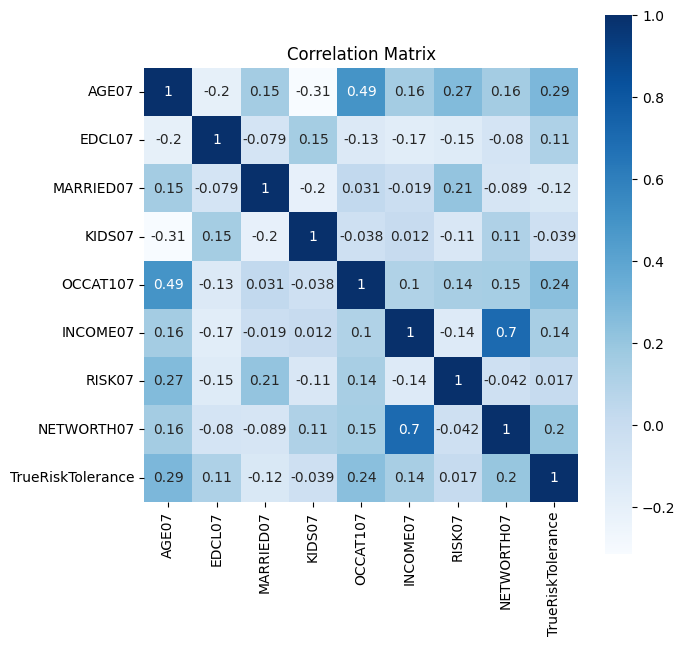

In [42]:
# correlation
correlation = dataset3.corr()
plt.figure(figsize=(7,7))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='Blues')
plt.show()

Observando o gráfico de correlação acima, o patrimônio líquido e a renda estão positivamente correlacionados com a tolerância ao risco. Com o aumento do número de filhos e o casamento, a tolerância ao risco diminui. À medida que a disposição para assumir riscos diminui, a tolerância ao risco também diminui. Em relação à idade, existe uma relação positiva com a tolerância ao risco.

De acordo com o artigo "Does Risk Tolerance Decrease With Age? (Hui Wang, Sherman Hanna)", a aversão relativa ao risco diminui conforme as pessoas envelhecem (ou seja, a proporção da riqueza líquida investida em ativos de risco aumenta com a idade), mantendo constantes outras variáveis. Portanto, a tolerância ao risco aumenta com a idade.

Resumindo, todas as variáveis e seus relacionamentos com a tolerância ao risco parecem intuitivos.

### Treino Teste Split

In [43]:
Y = dataset3["TrueRiskTolerance"]
X = dataset3.loc[:, dataset3.columns != 'TrueRiskTolerance']

validation_size = 0.2
seed = 3

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

### Teste Opções e Evolução de Metricas

In [50]:
num_folds = 10
scoring = 'r2'

### Modelos para Comparação

Modelos de Regressão

In [47]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#Ensable Models 
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

### K-folds cross validation

In [52]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)  # Add `shuffle=True`
    # Convertendo MSE (erro quadrático médio) para um valor positivo (Quanto menor, melhor)
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.102704 (0.179297)
LASSO: -0.041555 (0.109033)
EN: -0.047729 (0.108990)
KNN: -0.424571 (0.141433)
CART: -0.585841 (0.223891)
SVR: -0.127585 (0.101040)
ABR: -0.392823 (0.142282)
GBR: -0.621597 (0.136220)
RFR: -0.706459 (0.097641)
ETR: -0.696127 (0.145085)


### Comparação de algoritmos

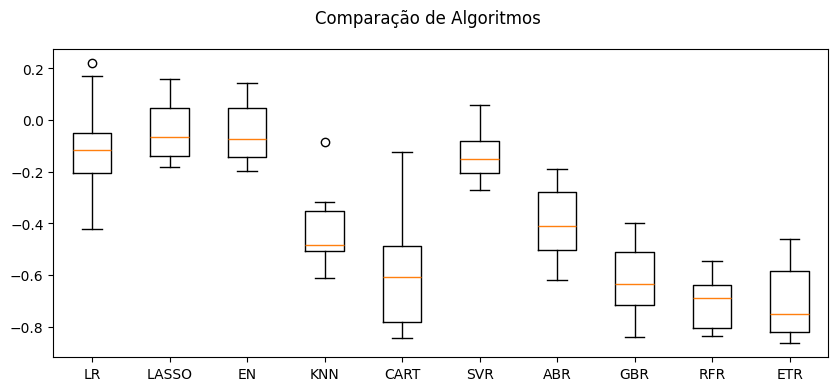

In [55]:
# Comparação de Algoritmos
fig = plt.figure()
fig.suptitle('Comparação de Algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(10,4)
plt.show()

Os modelos não lineares têm um desempenho melhor do que os modelos lineares, o que indica que existe uma relação não linear entre a tolerância ao risco e as diferentes variáveis usadas para prevê-la. Como a regressão por random forest é um dos melhores métodos, usaremos ela para a próxima etapa de busca em grade (grid search).

### Evoluindo o modelo usando Grid Search

Encontrando os melhores parametros par o modelo que teve melhor desempenho

In [57]:
# Grid Search : RandomForestRegressor

param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.712706 using {'n_estimators': 350}
0.693437 (0.103462) with: {'n_estimators': 50}
0.702051 (0.109835) with: {'n_estimators': 100}
0.711389 (0.095230) with: {'n_estimators': 150}
0.710581 (0.090529) with: {'n_estimators': 200}
0.701822 (0.108609) with: {'n_estimators': 250}
0.709348 (0.105672) with: {'n_estimators': 300}
0.712706 (0.104338) with: {'n_estimators': 350}
0.707928 (0.106560) with: {'n_estimators': 400}


Para cada número de árvores testado, temos:

- O score médio (primeiro número)

- O desvio padrão (entre parênteses)

- O parâmetro testado

O melhor desempenho foi alcançado com 350 árvores (score 0.7127)

Podemos observar que:

O desempenho geralmente melhora conforme aumentamos o número de árvores

Mas após 350 árvores, o desempenho começa a cair ligeiramente

O desvio padrão (variação nos resultados) se mantém relativamente estável

### Resultados no Dataset de teste

In [58]:
model = RandomForestRegressor(n_estimators = 250)
model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=250)

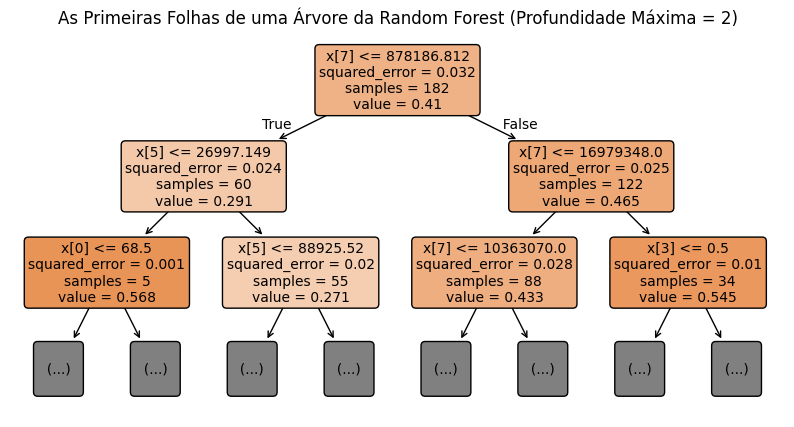

In [62]:
from sklearn.tree import plot_tree
# Selecionar a primeira árvore da floresta (índice 0)
arvore_para_plotar = model.estimators_[0]

# Definir a profundidade máxima para visualização (ajuste conforme necessário)
profundidade_maxima = 2  # Exibe a raiz e os próximos 2 níveis

# Plotar a árvore com a profundidade máxima especificada
plt.figure(figsize=(10, 5))
plot_tree(arvore_para_plotar, filled=True, rounded=True, fontsize=10, max_depth=profundidade_maxima)
plt.title(f"As Primeiras Folhas de uma Árvore da Random Forest (Profundidade Máxima = {profundidade_maxima})")
plt.show()

In [63]:
from sklearn.metrics import r2_score
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))

0.9647548800990349


In [64]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.007271835209875136
0.7770835616115772


### Feature Importance

[0.21293258 0.02574146 0.01366448 0.04416555 0.0250512  0.23839406
 0.05397725 0.38607342]


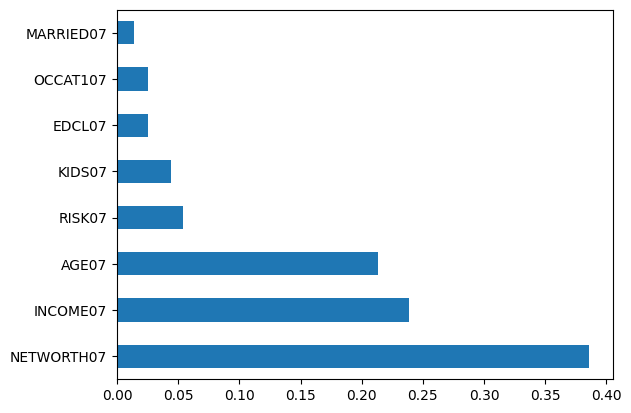

In [65]:
import pandas as pd
import numpy as np
model = RandomForestRegressor(n_estimators= 200,n_jobs=-1)
model.fit(X_train,Y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Salvando o Modelo

In [66]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [67]:
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
predictions = loaded_model.predict(X_validation)
result = mean_squared_error(Y_validation, predictions)
print(r2_score(Y_validation, predictions))
print(result)

0.7722737158842568
0.007428738871923832


### Conclusão 

Observamos que existe uma relação não linear entre as variáveis e a tolerância ao risco. Renda e patrimônio líquido, seguidos por idade e disposição para assumir riscos, são as principais variáveis para determinar a tolerância ao risco. Essas variáveis são consideradas fundamentais para modelar a tolerância ao risco em diversos estudos da literatura.